In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from matplotlib import rcParams

## Load data

In [37]:

types = np.load("/home/veronica/Desktop/UVM/matrices_all_cancer/final/types_in_matrix_all_cancer.npy")
breast_data = np.load("/home/veronica/Desktop/UVM/matrices_all_cancer/breast.npy")
start = 0
end = 0
for v in types:
    if v[0] == b"breast":
        start = v[2]
        end = v[3]

dictionary = np.load("/home/veronica/Desktop/UVM/mutation_signatures/datasets/dictionary_akkrokkio.npy")
coefficients = np.load("/home/veronica/Desktop/UVM/mutation_signatures/datasets/coefficients_akkrokkio.npy")
breast_data = np.load("/home/veronica/Desktop/UVM/matrices_all_cancer/breast.npy")
breast_coefficients = coefficients[int(start):int(end), :]

In [15]:
from dalila.sparse_coding import SparseCoding
from dalila.penalty import L1Penalty
coder = SparseCoding(penalty=L1Penalty(1), non_negativity="both")
coder.fit(breast_data, dictionary)

SparseCoding(non_negativity='both',
       penalty=<dalila.penalty.L1Penalty object at 0x7fa4e8d71fd0>,
       random_state=None)

In [19]:
breast_coefficients = coder.coefficients()
print(breast_coefficients)

[[ 0.          0.89138728  0.         ...,  0.          0.          0.        ]
 [ 5.23023239  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.44429146  0.          0.         ...,  3.09163897  0.          0.        ]
 [ 0.          0.60216634  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.58497202  0.          0.        ]]


## Transform coefficient matrix into percentages

In [38]:
percentages = np.zeros_like(breast_coefficients)

for sample in range(breast_coefficients.shape[0]):
    total = np.sum(breast_coefficients[sample,:])
#    print(total)
    if(total != 0):
        percentages[sample,:] = breast_coefficients[sample, :] / total 

print(percentages)

[[ 0.07553941  0.09637747  0.         ...,  0.04676907  0.          0.01037356]
 [ 0.26544956  0.02283801  0.         ...,  0.          0.          0.        ]
 [ 0.09635933  0.01703168  0.09839108 ...,  0.04872053  0.0514432
   0.02573276]
 ..., 
 [ 0.09307206  0.03641505  0.11397664 ...,  0.07107965  0.01545865  0.        ]
 [ 0.06322202  0.00631814  0.03749182 ...,  0.06376016  0.          0.        ]
 [ 0.          0.07009862  0.         ...,  0.01151225  0.09090303  0.        ]]


## For all the atoms find the highest percentage available

In [39]:
max_indices = np.zeros((percentages.shape[1]))
max_values = np.zeros((percentages.shape[1]))

for atom in range(percentages.shape[1]):
    max_indices[atom] = np.argmax(percentages[:,atom])
    #print(max_indices[atom])
    max_values[atom] = percentages[int(max_indices[atom]), atom]
   # print(max_values[atom])
#     print(breast_coefficients[int(max_indices[atom]), atom])
#     print(np.amax(dictionary[atom,:]))
print(breast_coefficients[int(max_indices[5]),:])
print(percentages[int(max_indices[5]),:])
print(percentages[int(max_indices[5]),5])

[  2.11468384   0.           1.16668515   0.           0.          12.59424369
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           1.4804323    0.           0.           0.24577397
   0.           0.        ]
[ 0.12014007  0.          0.06628208  0.          0.          0.71550808
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.08410678  0.          0.          0.01396299
  0.          0.        ]
0.715508080347


## Plot the atom and the related sample

In [25]:
def plot(dictionary, sample):
    # get all mutations with context
    features = np.load("/home/veronica/Desktop/UVM/mutation_signatures/datasets/features.npy")
    # atoms normalization
   # for r in range(dictionary.shape[0]):
     #   dictionary[r, :] /= np.sum(dictionary[r, :])

    cm = plt.cm.get_cmap('RdYlBu_r')
    colors = cm(np.linspace(0, 1, 6))

    _max = np.amax(np.amax(dictionary, axis=0)) + 0.05
    cols = 1
    rows = dictionary.shape[0]

    # start plot
    fig = plt.figure(figsize=(15, 10))

    #for k in range(dictionary.shape[0]):
    length = len(dictionary)
    x = np.arange(0, length)
    w = dictionary
    #ax = fig.add_subplot(rows, cols, k + 1)

    #if k == 0:  # saving first subplot for legend
     #   ax1 = ax

    weights = np.zeros(6)
    for j in range(6):
        i1 = 16 * j
        i2 = 16 * (j + 1)
        weights[j] = np.sum(w[i1:i2])

    N, bins, patches = plt.hist(x, bins=length, weights=w)
    width = patches[1].get_width()
    points = np.linspace(0, 95, 6)
    for k in range(6):
        plt.axvline(x=16*(k+1)*width, color='k', linestyle='dashed',
                   linewidth=1)

    N1, bins1, patches1 = plt.hist(x, bins=length, weights=sample,
                                   alpha=0.5)
    plt.xlim((0, 96))
    plt.ylim((0, _max))
    plt.xticks(bins+patches[0].get_width()/2 , features, rotation='vertical')
    rcParams.update({'font.size': 8})

    # colors labels
    labels = ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"]
    for bin_size, _bin, patch in zip(N, bins, patches):
        for l in range(6):
            patches[16*(l+1)-1].set_label(labels[l])
            if _bin < 16 * (l+1)-1:
                patch.set_facecolor(colors[l])
                break
    cm = plt.cm.get_cmap('PRGn_r')
    colors = cm(np.linspace(0, 1, 6))
    for bin_size, _bin, patch in zip(N1, bins1, patches1):
        for l in range(6):
            patches1[16*(l+1)-1].set_label(labels[l])
            if _bin < 16 * (l+1)-1:
                patch.set_facecolor(colors[l])
                break

    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='center',
               ncol=6,  mode='expand', borderaxespad=15.,
               numpoints=6, fontsize='xx-large')
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

The percentages of usage is:  0.715508080347


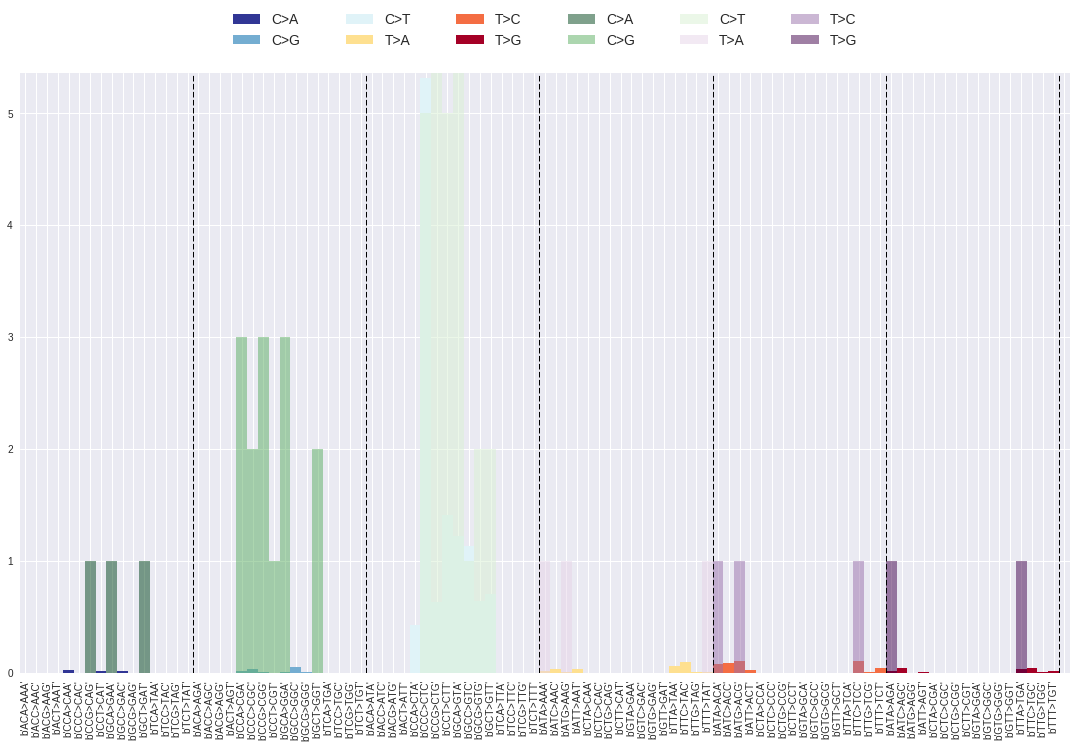

In [40]:
#for atom in range(len(max_indices)):
atom=5
print("The percentages of usage is: ", max_values[atom])

sample = breast_data[int(max_indices[atom]), :]

plot(dictionary[atom,:]*breast_coefficients[int(max_indices[atom]), atom], sample)
    
    
    #plot(dictionary[atom,:]*breast_coefficients[int(max_indices[atom]), atom], sample)

## Atom for breast cancer

In [41]:
percentages[np.where(percentages<0.25)] = 0
frequencies = np.zeros(28)
for atom in range(percentages.shape[1]):
    frequencies[atom]= len(np.nonzero(percentages[:,atom])[0])
print(frequencies)

[ 25.  52.   8.   4.   3.  21.  12.  34.   1.   6.  28.   7.  19.  25.   5.
  12.   1.  23.  10.  11.  12.  20.  81.  24.   5.   6.   4.  57.]


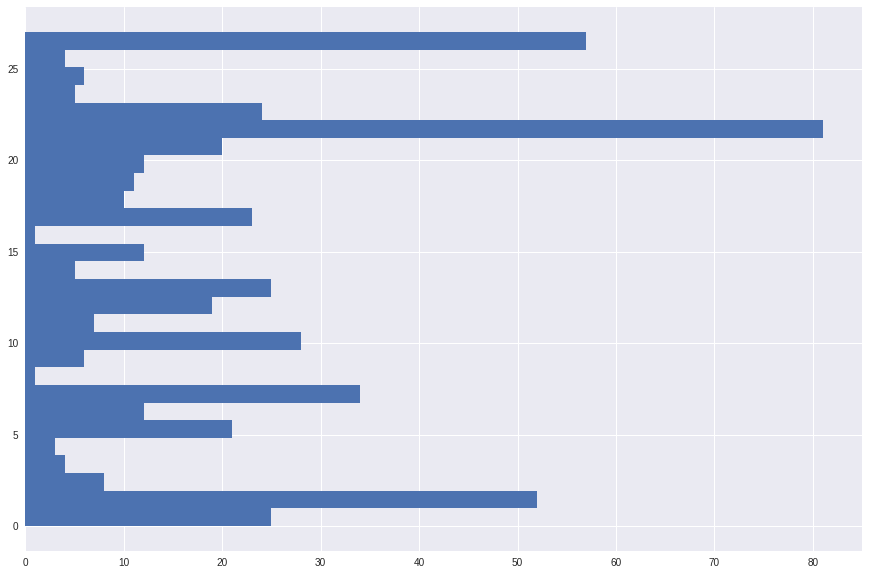

In [42]:
plt.figure(figsize=(15,10))
plt.hist(np.arange(28),weights=frequencies, bins=28, orientation="horizontal");
plt.show()

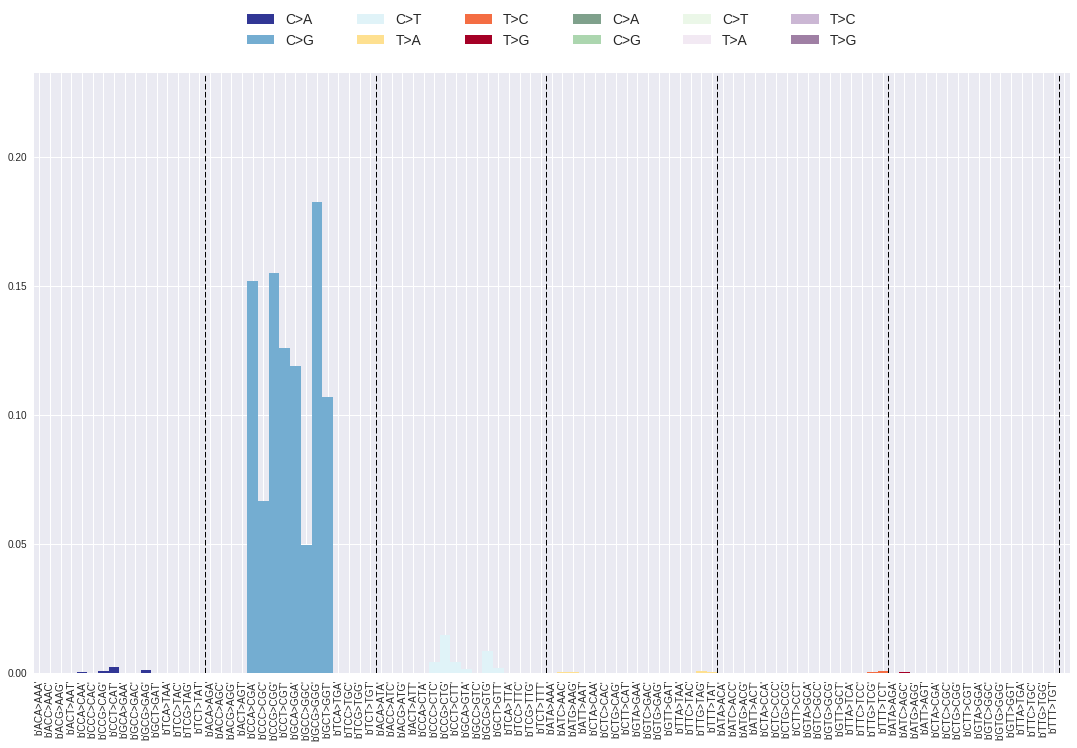

In [30]:
plot(dictionary[22,:], np.zeros(96))